## Pre-Procesing

In [1]:
from preprocessing import train_valid_test_split, combine_labels, get_attribute_dims

In [2]:
# Train-Test Split Folders
SOURCE_DATA_DIR = "data/ClothingAttributeDataset/images/"
TARGET_DATA_DIR = "data/ClothingAttributeDataset/"

# Labels File
LABEL_DIR = "data/ClothingAttributeDataset/labels/"
labels_file = "data/labels.csv"
label_values_file = "data/label_values.json"

# Train and Validation Images
TRAIN_IMAGES_FOLDER = "data/ClothingAttributeDataset/train/"
VALID_IMAGES_FOLDER = "data/ClothingAttributeDataset/valid/"
TEST_IMAGES_FOLDER = "data/ClothingAttributeDataset/test/"

In [3]:
train_valid_test_split(SOURCE_DATA_DIR, TARGET_DATA_DIR, train_size=0.75, valid_size=0.15)

In [12]:
!ls data/ClothingAttributeDataset/train | wc -l

1392


In [13]:
!ls data/ClothingAttributeDataset/valid | wc -l

278


In [14]:
!ls data/ClothingAttributeDataset/test | wc -l

186


In [6]:
labels_df = combine_labels(LABEL_DIR, labels_file, label_values_file)

In [7]:
# binary_columns = ['skin_exposure_GT', 'collar_GT', 'gender_GT', 'scarf_GT', 'necktie_GT',  'placket_GT']
# multi_columns = ['category_GT', 'neckline_GT', 'sleevelength_GT']
    
# color_columns = ['white_GT', 'yellow_GT', 'gray_GT', 'green_GT', 'blue_GT', 'brown_GT', 'red_GT',
#                  'cyan_GT', 'black_GT', 'purple_GT', 'many_colors_GT']
# pattern_columns = ['pattern_spot_GT', 'pattern_solid_GT', 'pattern_graphics_GT', 
#                   'pattern_plaid_GT', 'pattern_stripe_GT', 'pattern_floral_GT']

## Build Models

In [3]:
from classifiers import get_pretrained_model, create_attributes_fc_model
from utils import is_gpu_available

In [4]:
target_dims = get_attribute_dims(label_values_file)

In [5]:
target_dims

{'category_GT': 7,
 'collar_GT': 2,
 'gender_GT': 2,
 'neckline_GT': 3,
 'necktie_GT': 2,
 'pattern_GT': 6,
 'placket_GT': 2,
 'scarf_GT': 2,
 'skin_exposure_GT': 2,
 'sleevelength_GT': 3}

In [6]:
use_gpu = is_gpu_available()

## Build Dense Models

In [22]:
alexnet_conv, alexnet_fc, fc_dim = get_pretrained_model("alexnet", pop_last_pool_layer=False, use_gpu=use_gpu)

In [23]:
alexnet_conv

Sequential (
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU (inplace)
  (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU (inplace)
  (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU (inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU (inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
)

In [24]:
alexnet_fc

Sequential (
  (0): Dropout (p = 0.5)
  (1): Linear (9216 -> 4096)
  (2): ReLU (inplace)
  (3): Dropout (p = 0.5)
  (4): Linear (4096 -> 4096)
  (5): ReLU (inplace)
  (6): Linear (4096 -> 1000)
)

In [19]:
attribute_models = create_attributes_fc_model(alexnet_fc, alexnet_conv, fc_dim, 
                                target_dims, "weights/",
                                labels_file, 
                                TRAIN_IMAGES_FOLDER, 
                                VALID_IMAGES_FOLDER, 
                                num_epochs=1, 
                                use_gpu=use_gpu,
                                is_train=False)

Processing Attribute: placket_GT
Processing Attribute: category_GT
Processing Attribute: pattern_GT
Processing Attribute: neckline_GT
Processing Attribute: sleevelength_GT
Processing Attribute: gender_GT
Processing Attribute: collar_GT
Processing Attribute: skin_exposure_GT
Processing Attribute: scarf_GT
Processing Attribute: necktie_GT


In [20]:
attribute_models

{'category_GT': AttributeModel (
   (model): Sequential (
     (0): Dropout (p = 0.5)
     (1): Linear (9216 -> 4096)
     (2): ReLU (inplace)
     (3): Dropout (p = 0.5)
     (4): Linear (4096 -> 4096)
     (5): ReLU (inplace)
     (6): Linear (4096 -> 7)
   )
 ), 'collar_GT': AttributeModel (
   (model): Sequential (
     (0): Dropout (p = 0.5)
     (1): Linear (9216 -> 4096)
     (2): ReLU (inplace)
     (3): Dropout (p = 0.5)
     (4): Linear (4096 -> 4096)
     (5): ReLU (inplace)
     (6): Linear (4096 -> 2)
   )
 ), 'gender_GT': AttributeModel (
   (model): Sequential (
     (0): Dropout (p = 0.5)
     (1): Linear (9216 -> 4096)
     (2): ReLU (inplace)
     (3): Dropout (p = 0.5)
     (4): Linear (4096 -> 4096)
     (5): ReLU (inplace)
     (6): Linear (4096 -> 2)
   )
 ), 'neckline_GT': AttributeModel (
   (model): Sequential (
     (0): Dropout (p = 0.5)
     (1): Linear (9216 -> 4096)
     (2): ReLU (inplace)
     (3): Dropout (p = 0.5)
     (4): Linear (4096 -> 4096)
     (

## Fully FCN Model

In [7]:
pretrained_conv_model, _, _ = get_pretrained_model("vgg16", pop_last_pool_layer=True, use_gpu=use_gpu)

In [8]:
from classifiers import AttributeFCN, create_attributes_model

In [11]:
dict(list(target_dims.items())[:3])

{'collar_GT': 2, 'scarf_GT': 2, 'sleevelength_GT': 3}

In [14]:
!ls weights/vgg16-fcn-3/

category_GT.pth  neckline_GT.pth  placket_GT.pth	sleevelength_GT.pth
collar_GT.pth	 necktie_GT.pth   scarf_GT.pth
gender_GT.pth	 pattern_GT.pth   skin_exposure_GT.pth


In [ ]:
attribute_models = create_attributes_model(AttributeFCN, 512, pretrained_conv_model,
                                target_dims, 
#                                 dict(list(target_dims.items())[:3]),
                                "weights/vgg16-fcn-4/",
                                labels_file, 
                                 TRAIN_IMAGES_FOLDER, 
                                 VALID_IMAGES_FOLDER, 
                                 num_epochs=1, 
                                 is_train=True,
                                 use_gpu=use_gpu)

In [11]:
attribute_models = create_attributes_model(AttributeFCN, 512, pretrained_conv_model,
                                target_dims, 
#                                 dict(list(target_dims.items())[:3]),
                                "weights/vgg16-fcn-test/",
                                labels_file, 
                                 TRAIN_IMAGES_FOLDER, 
                                 VALID_IMAGES_FOLDER, 
                                 num_epochs=5, 
                                 is_train=True,
                                 use_gpu=use_gpu)

Processing Attribute: scarf_GT
Start Training for: scarf_GT
LR is set to 0.01
train Epoch 0/4 Loss: 0.0195 Acc: 0.8114
valid Epoch 0/4 Loss: 0.0171 Acc: 0.8347
Training completed in 1.000000m 39.057248s
Best val Acc: 0.875000
Processing Attribute: category_GT
Start Training for: category_GT
LR is set to 0.01
train Epoch 0/4 Loss: 0.0623 Acc: 0.3644
valid Epoch 0/4 Loss: 0.0604 Acc: 0.4304
Training completed in 1.000000m 8.012913s
Best val Acc: 0.575949
Processing Attribute: necktie_GT
Start Training for: necktie_GT
LR is set to 0.01
train Epoch 0/4 Loss: 0.0181 Acc: 0.8775
valid Epoch 0/4 Loss: 0.0164 Acc: 0.9046
Training completed in 1.000000m 44.066475s
Best val Acc: 0.950382
Processing Attribute: neckline_GT
Start Training for: neckline_GT
LR is set to 0.01
train Epoch 0/4 Loss: 0.0342 Acc: 0.4840
valid Epoch 0/4 Loss: 0.0317 Acc: 0.6158
Training completed in 1.000000m 20.402497s
Best val Acc: 0.631579
Processing Attribute: skin_exposure_GT
Start Training for: skin_exposure_GT
LR is

In [ ]:
# attribute_models = create_attributes_model(pretrained_fc, pretrained_conv_model, fc_dim, target_dims, "weights-fcn/",
#                                 labels_file, 
#                                  TRAIN_IMAGES_FOLDER, 
#                                  VALID_IMAGES_FOLDER, 
#                                  num_epochs=1, is_train=True)

## Evaluate the Model

In [7]:
import numpy as np
from scipy.misc import imread, imsave, imresize
from matplotlib import pyplot as plt

%matplotlib inline

In [8]:
import torch

from preprocessing import image_loader, load_label_values
from classifiers import predict_attributes, get_pretrained_model
from classifiers import AttributeFCN, create_attributes_model

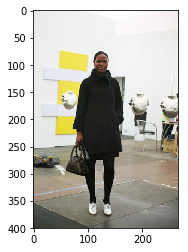

In [9]:
img = imread("data/ClothingAttributeDataset/valid/000032.jpg")
plt.imshow(img)

In [10]:
pretrained_conv_model, _, _ = get_pretrained_model("alexnet", pop_last_pool_layer=True, use_gpu=use_gpu)

In [11]:
target_dims = get_attribute_dims(label_values_file)

In [45]:
attribute_models = create_attributes_model(AttributeFCN, 512, pretrained_conv_model,
                                target_dims, 
                                # dict(list(target_dims.items())[:3]),
                                "weights/vgg16-fcn-4",
                                labels_file, 
                                TRAIN_IMAGES_FOLDER, 
                                VALID_IMAGES_FOLDER, 
                                num_epochs=1, 
                                is_train=False,
                                use_gpu=use_gpu)

Processing Attribute: collar_GT
Processing Attribute: scarf_GT
Processing Attribute: sleevelength_GT
Processing Attribute: pattern_GT
Processing Attribute: gender_GT
Processing Attribute: placket_GT
Processing Attribute: skin_exposure_GT
Processing Attribute: necktie_GT
Processing Attribute: category_GT
Processing Attribute: neckline_GT


In [13]:
# use_gpu = torch.cuda.is_available()

# def 
# if use_gpu:
#     pretrained_conv_model = pretrained_conv_model.cuda()
#     for model in attribute_models.values():
#         model.cuda()

In [17]:
label_values = load_label_values(label_values_file)

In [15]:
image_url = "data/ClothingAttributeDataset/valid/000026.jpg"

In [23]:
image_features = image_loader(image_url, use_gpu=True)

In [30]:
alexnet_conv(image_features).size()

torch.Size([1, 256, 11, 7])

In [24]:
image_features.size()

torch.Size([1, 3, 400, 266])

In [27]:
pretrained_features = pretrained_conv_model(image_features)

In [28]:
pretrained_features.size()

torch.Size([1, 512, 25, 16])

In [21]:
# Dense Layer FC

results = predict_attributes(image_url, alexnet_conv, attribute_models, 
                            attribute_idx_map=label_values["idx_to_names"],
                            flatten_pretrained_out=True, 
                            use_gpu=use_gpu)

Predicting placket_GT


RuntimeError: size mismatch at /py/conda-bld/pytorch_1490826558918/work/torch/lib/THC/generic/THCTensorMathBlas.cu:243

In [54]:
results = predict_attributes(image_url, pretrained_conv_model, attribute_models, 
                            attribute_idx_map=label_values["idx_to_names"],
                            flatten_pretrained_out=False, 
                            use_gpu=use_gpu)

Predicting collar_GT
Predicting skin_exposure_GT
Predicting sleevelength_GT
Predicting pattern_GT
Predicting gender_GT
Predicting scarf_GT
Predicting placket_GT
Predicting category_GT
Predicting necktie_GT
Predicting neckline_GT


In [49]:
results

{'category_GT': ('Suit', 0.87647313),
 'collar_GT': ('Has Collar', 0.99999976),
 'gender_GT': ('Is Male', 0.90994614),
 'neckline_GT': ('V-shape', 0.98505867),
 'pattern_GT': ('Solid', 0.99999964),
 'placket_GT': ('Has Placket', 1.0),
 'sleevelength_GT': ('Long sleeves', 0.99999988)}

In [52]:
results

{'category_GT': ('Suit', 0.86048335),
 'collar_GT': ('Has Collar', 0.99999988),
 'gender_GT': ('Is Male', 1.0),
 'neckline_GT': ('V-shape', 0.98093021),
 'pattern_GT': ('Solid', 0.99998975),
 'placket_GT': ('Has Placket', 0.99999988),
 'sleevelength_GT': ('Long sleeves', 0.99999845)}

In [55]:
results

{'category_GT': ('Suit', 0.63289624),
 'collar_GT': ('Has Collar', 0.99974996),
 'gender_GT': ('Is Male', 0.99433702),
 'neckline_GT': ('V-shape', 0.93334353),
 'pattern_GT': ('Solid', 0.99988604),
 'placket_GT': ('Has Placket', 0.99993217),
 'sleevelength_GT': ('Long sleeves', 0.99996793)}

## Visualize FCN

In [23]:
import scipy.misc

In [33]:
conv_layer_out = attribute_models["sleevelength_GT"].conv_model(pretrained_features)

In [34]:
conv_arr2 = conv_layer_out[0].data.cpu().numpy()

In [25]:
conv_arr = conv_layer_out[0].data.cpu().numpy()

In [35]:
np.mean(conv_arr2, axis=(1, 2))

array([-0.14064956, -0.18462452, -0.19912066,  0.39244321,  0.11226825,
       -0.08380169,  0.19703917], dtype=float32)

In [26]:
np.mean(conv_arr, axis=(1, 2))

array([ 0.03558936, -0.21509379, -0.2884874 ,  0.58108062,  0.22265822,
       -0.4062033 ,  0.08262175], dtype=float32)

In [28]:
from torchvision import transforms

In [29]:
image_features.size()

torch.Size([1, 3, 224, 224])

In [55]:
# transforms.ToPILImage()(image_features[0].data.cpu())

In [38]:
image_features[0].data.cpu().numpy().shape

(3, 400, 266)

In [54]:
# plt.imshow(scipy.misc.imresize(scipy.misc.imread(image_url), (400, 266)))

In [75]:
conv_out = conv_layer_out[0].data.cpu().numpy()

In [67]:
conv_out_exp = np.exp(conv_out)

In [68]:
conv_out_sum = np.sum(conv_out_exp, 0)

In [69]:
conv_out_smax = (conv_out_exp / conv_out_sum)

In [37]:
plt.imshow(scipy.misc.imresize(scipy.misc.imread(image_url), (400, 266)))
plt.imshow(scipy.misc.imresize(conv_out[3], (400, 266), interp='nearest'), 
           alpha=0.5, cmap="cool")

NameError: name 'scipy' is not defined

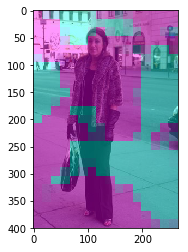

In [71]:
plt.imshow(scipy.misc.imresize(scipy.misc.imread(image_url), (400, 266)))
plt.imshow(scipy.misc.imresize(conv_out_smax[2], (400, 266), interp='nearest'), 
           alpha=0.4, cmap="cool")

## Confusion Matrix

In [57]:
for data in dset_loaders["train"]:
    inputs, labels = data
    if use_gpu:
        X = Variable(inputs.cuda())
    else:
        X = Variable(inputs)
    results = model(X)
    if use_gpu:
        results = results.cpu()
    break

NameError: name 'dset_loaders' is not defined

In [25]:
data = [{"placket_GT": ["Has Placket", "1.0%"], "sleevelength_GT": ["Long sleeves", "1.0%"], "category_GT": ["Suit", "1.0%"], "pattern_GT": ["Solid", "1.0%"], "neckline_GT": ["V-shape", "1.0%"], "collar_GT": ["Has Collar", "1.0%"], "gender_GT": ["Is Male", "1.0%"]}]

In [26]:
import pandas as pd

In [28]:
data

[{'category_GT': ['Suit', '1.0%'],
  'collar_GT': ['Has Collar', '1.0%'],
  'gender_GT': ['Is Male', '1.0%'],
  'neckline_GT': ['V-shape', '1.0%'],
  'pattern_GT': ['Solid', '1.0%'],
  'placket_GT': ['Has Placket', '1.0%'],
  'sleevelength_GT': ['Long sleeves', '1.0%']}]

In [ ]:
for 

In [31]:
df = pd.DataFrame(data[0]).T

In [32]:
df.columns = ["Prediction", "Probability"]

In [35]:
df.index = df.index.str.replace("_GT", "").str.capitalize()

In [36]:
df

,Prediction,Probability
Category,Suit,1.0%
Collar,Has Collar,1.0%
Gender,Is Male,1.0%
Neckline,V-shape,1.0%
Pattern,Solid,1.0%
Placket,Has Placket,1.0%
Sleevelength,Long sleeves,1.0%
